In [1]:
import os
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np
import glob

# class info
classes = np.array(['11-20','21-30', '31-40','41-50','51-60','61-'])
num_classes = len(classes)
temp = classes.tolist()

def create_graph(model_path):
    with gfile.FastGFile(model_path, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name = '')
        print ('selesai')

In [2]:
def extract_features(image_paths, verbose = False):
    features = []
    cls = []
    
    with tf.Session() as sess:
        flattened_tensor = sess.graph.get_tensor_by_name('pool_3:0')
        
        for fld in classes:
            index = temp.index(fld)
            path = os.path.join(image_paths, fld, '*.jpg')
            files = glob.glob(path)
            
            for fl in files:
                label = np.zeros(len(classes))
                label[index] = 1
                print '{0}\r'.format(fl),
                image_data = gfile.FastGFile(fl, 'rb').read()
                feature = sess.run(flattened_tensor, {
                        'DecodeJpeg/contents:0': image_data
                })
                features.append(feature)
                cls.append(label)
    return features, cls

In [3]:
path = 'inception_dec_2015/tensorflow_inception_graph.pb'
create_graph(path)

selesai


In [4]:
image_path = 'age_training(2)/'
images, cls = extract_features(image_path, verbose = False) 

In [5]:
num_sample = len(images)
print num_sample

29086


In [6]:
transfer_values = np.asarray(images)
transfer_values = transfer_values.reshape((num_sample, 2048))
print transfer_values.shape

(29086, 2048)


In [7]:
cls = np.asarray(cls)
cls = cls.astype(int)
print cls.shape

(29086, 6)


In [8]:
kelas = []
a , b = cls.shape

for i in range(a):
    for j in range(b):
        if (cls[i,j] == 1):
            kelas.append(j)

print ('selesai')

selesai


In [9]:
image_path_test = 'age_testing2/'
images_test, cls_test = extract_features(image_path_test, verbose = False) 
print "selesai"

selesaiting2/61-/56-604026.jpgjpg


In [11]:
num_test = len(images_test)
print num_test

1688


In [12]:
transfer_values_test = np.asarray(images_test)
transfer_values_test = transfer_values_test.reshape((num_test, 2048))
print transfer_values_test.shape

cls_test = np.asarray(cls_test)
cls_test = cls_test.astype(int)
print cls_test.shape

(1688, 2048)
(1688, 6)


In [13]:
kelas_test = []
a , b = cls_test.shape

for i in range(a):
    for j in range(b):
        if (cls_test[i,j] == 1):
            kelas_test.append(j)

print ('selesai')

selesai


In [391]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
transfer_values_reduced = pca.fit_transform(transfer_values_test)

In [392]:
import matplotlib.pyplot as plt

def plot_scatter(values, cls):
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0, 1, num_classes))
    
    colors = cmap[cls]
    x = values[:, 0]
    y = values[:, 1]
    
    plt.scatter(x, y, color=colors)
    plt.show()

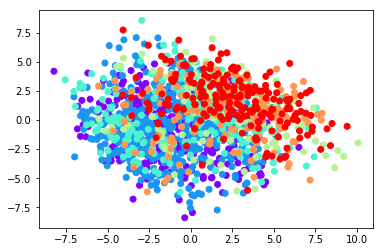

In [393]:
plot_scatter(transfer_values_reduced, kelas_test)

In [394]:
transfer_values_new = transfer_values_test
from sklearn.manifold import TSNE
pca_2 = PCA(n_components= 100)
transfer_values_50d = pca_2.fit_transform(transfer_values_new)
print transfer_values_50d.shape

(1585, 100)


In [395]:
tsne = TSNE(n_components = 2)
transfer_values_reduced = tsne.fit_transform(transfer_values_50d)
print transfer_values_reduced.shape

(1585, 2)


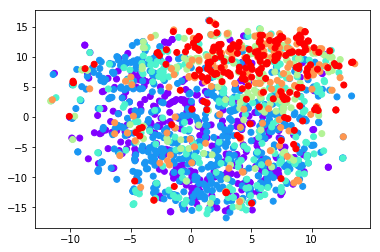

In [396]:
plot_scatter(transfer_values_reduced, kelas_test)

In [14]:
num_test = len(images_test)
print num_test
transfer_values_test = np.asarray(images_test)
transfer_values_test = transfer_values_test.reshape((num_test, 2048))
print transfer_values_test.shape

1688
(1688, 2048)


In [15]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_fc_layer(input,
                 num_inputs,
                 num_outputs,
                 use_relu = True):
    weights = new_weights(shape = [num_inputs, num_outputs])
    biases = new_biases(length = num_outputs)
    
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

In [16]:
feature_size_flat = 2048
dropout = 0.75

x = tf.placeholder(tf.float32, shape=[None, feature_size_flat], name = 'x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name = 'y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

layer_fc1 = new_fc_layer(input = x,
                        num_inputs = 2048,
                        num_outputs = 1000,
                        use_relu = True)
#layer_fc1 = tf.nn.dropout(layer_fc1, dropout)

layer_fc2 = new_fc_layer(input = layer_fc1,
                        num_inputs = 1000,
                        num_outputs = 1000,
                        use_relu = True)
layer_fc2 = tf.nn.dropout(layer_fc2, dropout)

layer_fc3 = new_fc_layer(input = layer_fc2,
                        num_inputs = 1000,
                        num_outputs = 1000,
                        use_relu = True)
layer_fc3 = tf.nn.dropout(layer_fc3, dropout)

layer_fc4 = new_fc_layer(input = layer_fc3,
                        num_inputs = 1000,
                        num_outputs = 1000,
                        use_relu = True)
layer_fc4 = tf.nn.dropout(layer_fc4, dropout)

layer_fc5 = new_fc_layer(input = layer_fc4,
                        num_inputs = 1000,
                        num_outputs = 6,
                        use_relu = True)
layer_fc5 = tf.nn.dropout(layer_fc5, dropout)

y_pred = tf.nn.softmax(layer_fc5)
y_pred_cls = tf.argmax(y_pred, dimension = 1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = layer_fc5, labels = y_true)

cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-5).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [17]:
train_acc = []
test_acc = []

In [24]:
import time
from datetime import timedelta
from sklearn.utils import shuffle

saver = tf.train.Saver()
session = tf.Session()
save_path = "age_transfer2/age_transfer2"
session.run(tf.global_variables_initializer())

train_batch = 3000

def optimize(num_iterations):
    global transfer_values
    global cls
    
    start_time = time.time()
    
    best_acc = 0
    best_acc_test = 0
    
    batch_ke = 0
    
    for i in range(num_iterations):
        batch_ke += 1
        
        if(batch_ke * train_batch > num_sample):
            batch_ke = 1
            transfer_values, cls = shuffle(transfer_values, cls)
            
        batas_bawah = (batch_ke-1) * train_batch
        batas_atas = batch_ke * train_batch
        x_batch = transfer_values[batas_bawah:batas_atas]
        y_batch = cls[batas_bawah:batas_atas]
        
        x_batch_test = transfer_values_test[ 0 : num_test]
        y_batch_test = cls_test[ 0 : num_test]
        
        feed_dict_train = {x: x_batch, y_true: y_batch}
        feed_dict_test = {x: x_batch_test, y_true: y_batch_test}
        
        session.run(optimizer, feed_dict = feed_dict_train)
        
        msg = "epoch: {0:6}, train_accuarcy: {1:6.2}, test_accuracy: {2:6.4}  {3}"
        acc = session.run(accuracy, feed_dict = feed_dict_train)
        acc_test = session.run(accuracy, feed_dict = feed_dict_test)
        
        train_acc.append(acc)
        test_acc.append(acc_test)
        
        if (acc_test > best_acc_test):
            sign = '*'
            best_acc_test = acc_test
            saver.save(sess=session, save_path=save_path)
        else:
            sign = '-'
        print msg.format(i, acc, acc_test, sign)
    
    session.close()
    end_time = time.time()
    time_dif = end_time - start_time
    print('time elapsed:' + str(timedelta (seconds = int(round(time_dif)))))

In [25]:
del train_acc[:]
del test_acc[:]

In [26]:
optimize(num_iterations = 10000)

epoch:      0, train_accuarcy:   0.12, test_accuracy: 0.1807  *
epoch:      1, train_accuarcy:   0.13, test_accuracy: 0.1635  -
epoch:      2, train_accuarcy:   0.13, test_accuracy: 0.1955  *
epoch:      3, train_accuarcy:   0.14, test_accuracy: 0.1534  -
epoch:      4, train_accuarcy:   0.15, test_accuracy: 0.1641  -
epoch:      5, train_accuarcy:   0.15, test_accuracy: 0.1712  -
epoch:      6, train_accuarcy:   0.15, test_accuracy: 0.1771  -
epoch:      7, train_accuarcy:   0.14, test_accuracy: 0.1807  -
epoch:      8, train_accuarcy:   0.15, test_accuracy: 0.1759  -
epoch:      9, train_accuarcy:   0.16, test_accuracy:  0.189  -
epoch:     10, train_accuarcy:   0.15, test_accuracy: 0.1748  -
epoch:     11, train_accuarcy:   0.15, test_accuracy:   0.17  -
epoch:     12, train_accuarcy:   0.14, test_accuracy: 0.1694  -
epoch:     13, train_accuarcy:   0.14, test_accuracy: 0.1813  -
epoch:     14, train_accuarcy:   0.15, test_accuracy: 0.1736  -
epoch:     15, train_accuarcy:   0.14, t

In [27]:
print (max(test_acc))

0.381517


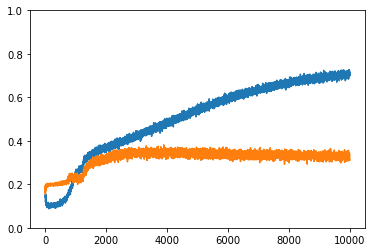

In [28]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(train_acc)
plt.plot(test_acc)
plt.ylim(0, 1)
plt.show()

In [29]:
kelas_test = []
cls_test = np.asarray(cls_test)
a , b = cls_test.shape

for i in range(a):
    for j in range(b):
        if (cls_test[i,j] == 1):
            kelas_test.append(j)

print ('selesai')
kelas_test = np.asarray(kelas_test)
np.set_printoptions(threshold=np.nan)
print kelas_test

selesai
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 

In [30]:
session2 = tf.Session()
saver.restore(sess = session2, save_path = save_path)
x_batch_test = transfer_values_test[ 0 : num_test]
y_batch_test = cls_test[ 0 : num_test]
feed_dict_test = {x: x_batch_test, y_true: y_batch_test}
prediction_test = session2.run(y_pred_cls, feed_dict = feed_dict_test)
print prediction_test

[0 0 3 0 0 1 0 0 0 0 0 0 2 0 1 0 1 2 4 4 5 1 0 2 1 0 3 4 3 4 1 0 2 1 0 0 0
 0 0 2 1 2 3 1 1 0 0 1 2 3 3 0 1 3 0 2 0 0 0 1 2 1 1 0 1 1 2 0 0 1 0 1 0 0
 0 0 2 0 2 1 1 3 1 2 0 1 1 4 2 1 0 1 1 1 1 0 1 1 1 1 1 1 2 0 0 2 2 1 1 1 1
 0 1 1 5 0 0 0 1 1 1 1 2 2 0 0 2 1 2 2 2 1 1 3 1 1 3 3 1 1 1 1 0 1 0 1 2 0
 3 0 0 1 1 2 2 0 0 1 2 2 1 2 1 0 1 0 0 1 1 1 3 1 2 1 0 2 1 1 1 1 1 1 1 0 1
 2 0 1 1 4 0 1 3 4 4 1 1 1 2 1 2 2 1 3 1 3 1 0 1 1 0 3 0 1 1 2 0 0 3 2 4 3
 2 2 1 2 0 0 3 1 0 0 1 1 0 3 4 4 0 1 3 0 1 1 0 1 1 1 2 2 1 2 3 3 2 2 1 0 2
 1 2 1 1 1 2 1 2 3 1 1 0 1 0 1 1 1 1 1 3 1 0 0 0 1 0 2 1 1 2 3 2 2 3 1 2 2
 1 1 1 1 4 0 1 2 4 1 3 2 2 0 4 1 0 1 0 0 1 1 1 3 2 0 1 1 1 0 1 3 3 3 3 1 0
 2 1 4 1 0 3 1 2 1 3 1 2 4 3 1 0 2 2 2 2 3 2 4 1 0 0 1 2 2 1 1 1 1 2 3 1 1
 1 1 1 1 2 0 3 1 1 1 1 2 2 0 1 0 1 5 2 2 1 2 1 3 1 0 2 3 2 0 0 1 1 1 0 1 4
 3 2 0 1 2 1 2 1 0 4 0 1 1 0 2 1 1 1 2 2 2 1 2 2 1 1 0 1 4 2 1 3 1 3 2 2 2
 2 2 3 1 2 1 1 1 3 1 2 2 2 2 2 1 0 0 2 1 3 2 0 3 2 3 2 2 2 2 2 2 4 2 1 1 1
 0 3 0 2 1 1 0 2 0 0 1 2 

In [31]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 90 137  60  34  15   2]
 [ 67 213 151  59  14   1]
 [ 14  46  74  69  35   0]
 [  4   3  29  68  43   4]
 [  7  11  22  66 125  21]
 [  5   2   9  50 108  30]]


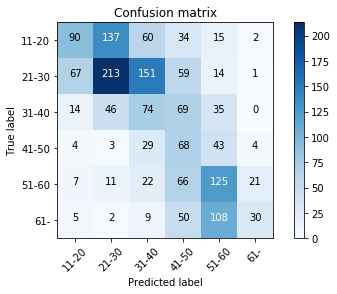

In [32]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(kelas_test, prediction_test)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix')
plt.show()

In [108]:
import cv2
def load_images(image_path):
    image_data = []
    for fld in classes:
        path = os.path.join(image_path, fld, '*.jpg')
        files = glob.glob(path)
            
        for fl in files:
            image = cv2.imread(fl)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_data.append(image)
    return image_data

In [109]:
image_data = load_images('age_testing2/')

In [130]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

def plot_sample_error(kelas_test, prediction_test, image_data):
    kelas_test, prediction_test, image_data = shuffle(kelas_test, prediction_test, image_data)
    error = []
    error_image = []
    error_label = []
    true_label = []
    
    number = 0;
    for i in kelas_test:
        true_result = kelas_test[number]
        pred_result = prediction_test[number]
        if (true_result != pred_result):
            error.append(number)
        number += 1
    for j in error:
        image = image_data[j]
        label = prediction_test[j]
        t_label = kelas_test[j]
        error_image.append(image)
        error_label.append(label)
        true_label.append(t_label)
        
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    number = 0
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(error_image[i])

        # Show true and predicted classes.
        if error_label is None:
            xlabel = "True: {0}".format(error_label[number])
        else:
            xlabel = "True: {0}, Pred: {1}".format(true_label[number], error_label[number])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
        number += 1
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    

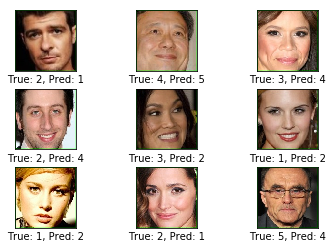

In [136]:
plot_sample_error(kelas_test, prediction_test, image_data)